# Image Masking Pipeline using SAM Model<br>
This Jupyter Notebook is a pipeline for masking processed IFCB images using the SAM model (GitHub: https://github.com/facebookresearch/segment-anything). The pipeline consists of three steps to ensure images are masked appropriately:<br>

**1- Automatic Input and Monitoring:**<br>
Inputs are automatically provided to the entire image. Use 4 corner points to assign background to images.<br>
Filter out images with scores lower than 0.05 or higher than 0.5<br>
Scores are monitored to check if images are masked appropriately.<br>
If images are not masked appropriately, proceed to Step 2.<br>
**2-Automatic Input for Remaining Images:**<br>
Another input is automatically provided to the model for images that were not appropriately masked in Step 1.<br>
Use a box as input for filtered images.<br>
Again, filter out images with scores lower than 0.05 or higher than 0.5.<br>
If images are still not masked appropriately, proceed to Step 3.<br>
**3-Manual Input for Remaining Images:**<br>
For images that are still not masked appropriately, a manual approach is applied.<br>
The image is plotted, and manual inputs are given.<br>
Segment them manually using green points to indicate the foreground and red points to indicate the background.<br>
Select the best mask <br>

**Requirements**<br>
Python 3.8 or higher<br>
PyTorch 1.7 or higher<br>
torchvision 0.8 or higher<br>
CUDA support (GPU) for faster execution<br>




In [2]:
#Step-1
#register the model 
from segment_anything import sam_model_registry,  SamPredictor
sam = sam_model_registry["vit_h"](checkpoint="C:/Users/kurta/Downloads/sam_vit_h_4b8939.pth")#pathway in computer where you download the model
predictor = SamPredictor(sam)

In [7]:
#STEP 1
#4 POINT WITH 0.5 <SCORES <0.5 THIS ONE GOES TO updated_process1.py
import os
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# Configuration
image_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed"
output_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed\deneme_SA4point"
flagged_folder = os.path.join(output_folder, "flagged")
os.makedirs(output_folder, exist_ok=True)
os.makedirs(flagged_folder, exist_ok=True)



# Function to show mask
def show_mask(mask, ax, color=[30/255, 144/255, 255/255, 0.6]):  # Blue color by default
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)
    ax.imshow(mask_image)

# Function to show points
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25) 

# Function to calculate segmentation score
def segmentation_score(boundary_image):
    """
    Placeholder function to calculate the segmentation score for a given boundary image.
    Assumes boundary_image is binary with segmented parts as 1 and background as 0.
    """
    score = np.sum(boundary_image) / boundary_image.size
    return score

# Helper function to get image corner points
def get_image_corners(image):
    h, w = image.shape[:2]
    return np.array([[0, 0], [0, h - 1], [w - 1, 0], [w - 1, h - 1]])

# Process images
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Set the image and provide the corner points
    predictor.set_image(image_rgb)
    input_points = get_image_corners(image_rgb)
    input_labels = np.array([0, 0, 0, 0])  # All corners as background (red)

    # Predict masks using the corner points
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        box=None,
        multimask_output=True,
    )

    # Select the best mask based on the highest score
    best_mask = masks[np.argmax(scores)]

    # Invert the mask to highlight foreground instead of background
    inverted_mask = np.logical_not(best_mask).astype(np.uint8)

    # Calculate the segmentation score
    seg_score = segmentation_score(inverted_mask)

    # Save the mask as a numpy array
    base_filename = os.path.splitext(image_file)[0]
    npy_output_path = os.path.join(output_folder, f"{base_filename}_masked.npy")
    np.save(npy_output_path, inverted_mask)

    # Save the mask as a binary image
    binary_output_path = os.path.join(output_folder, f"{base_filename}_masked.png")
    cv2.imwrite(binary_output_path, inverted_mask * 255)
    
    # Flag images based on segmentation score
    if seg_score > 0.50 or seg_score < 0.05:
        flagged_output_path = os.path.join(flagged_folder, f"{base_filename}_flagged.png")
        cv2.imwrite(flagged_output_path, inverted_mask * 255)


    # Display the image with the mask and save the plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    show_mask(inverted_mask, plt.gca())
    show_points(input_points, input_labels, plt.gca())
    plt.axis('off')
    plt.title(f"Image: {image_file} | Segmentation Score: {seg_score:.3f}")
    plot_output_path = os.path.join(output_folder, f"{base_filename}_plot.png")
    plt.savefig(plot_output_path)
    plt.close()

print(f"Processed {len(image_files)} images and saved results to {output_folder}")


Processed 405 images and saved results to D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed\deneme_SA4point


In [3]:
#FIND THE PROCESSED COUNTERPARTS FROM THE FLAGGED FOLDERS
#make low scored images subfolder and copy the processed images in a a subfolder for further analyzing in Step2 
import os
import shutil
from glob import glob

# Directories
flagged_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed\deneme_SA4point\flagged"
processed_folder_base = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed"
output_base_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed\deneme_SA4point\flagged\low_score_processedimages"
os.makedirs(output_base_folder, exist_ok=True)

# Get all original png files in the base folder recursively
processed_files = glob(os.path.join(processed_folder_base, '**/*.png'), recursive=True)
processed_files_dict = {os.path.basename(f): f for f in processed_files}

# Process flagged .png files
flagged_files = [f for f in os.listdir(flagged_folder) if f.endswith('_flagged.png')]
for flagged_file in flagged_files:
    # Get the corresponding original filename with .png extension
    processed_filename = flagged_file.replace('_flagged.png', '.png')
    
    # Check if the original file exists in the dictionary
    if processed_filename not in processed_files_dict:
        print(f"Original file not found for {flagged_file}")
        continue
    
    original_path = processed_files_dict[processed_filename]
    
    # Copy the original file to the output folder
    shutil.copy2(original_path, os.path.join(output_base_folder, processed_filename))

print(f"Processed {len(flagged_files)} files and moved the original files to the output folder.")


Processed 46 files and moved the original files to the output folder.


In [ ]:
#STEP 2
#APPLY THE SECOND VERSION (ONLY BOX) OF SA MODEL TO LOW SCORES
import os
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# Configuration
image_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed\deneme_SA4point\flagged\low_score_processedimages"
output_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed\deneme_SA4point\flagged\low_score_processedimages\SA_box_with_scores"
flagged_folder = os.path.join(output_folder, "flagged")
os.makedirs(output_folder, exist_ok=True)
os.makedirs(flagged_folder, exist_ok=True)

# Initialize the predictor (Assuming `sam_model_registry` and `SamPredictor` are properly configured)
predictor = SamPredictor(sam_model_registry["model_name"])  # Replace "model_name" with your model name

# Function to show mask
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])  # Blue color
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Function to show box
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# Function to calculate segmentation score
def segmentation_score(boundary_image):
    """
    Placeholder function to calculate the segmentation score for a given boundary image.
    Assumes boundary_image is binary with segmented parts as 1 and background as 0.
    """
    score = np.sum(boundary_image) / boundary_image.size
    return score

# Process images
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Set the image and provide bounding box
    predictor.set_image(image_rgb)

    # Get image dimensions to create a bounding box
    image_height, image_width = image_rgb.shape[:2]
    input_box = np.array([0, 0, image_width, image_height])  # [x1, y1, x2, y2]

    # Predict masks using the bounding box
    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=True,
    )

    # Select the mask with the second highest score
    sorted_indices = np.argsort(scores)
    second_best_mask_index = sorted_indices[-2]  # Second highest score index
    second_best_mask = masks[second_best_mask_index]
    second_best_score = scores[second_best_mask_index]

    # Invert the mask to highlight foreground instead of background
    inverted_mask = np.logical_not(second_best_mask).astype(np.uint8)

    # Calculate the segmentation score
    seg_score = segmentation_score(inverted_mask)

    # Save the mask as a numpy array
    base_filename = os.path.splitext(image_file)[0]
    npy_output_path = os.path.join(output_folder, f"{base_filename}_masked.npy")
    np.save(npy_output_path, inverted_mask)

    # Save the mask as a binary image
    binary_output_path = os.path.join(output_folder, f"{base_filename}_masked.png")
    cv2.imwrite(binary_output_path, inverted_mask * 255)

    # Flag images based on segmentation score
    if seg_score > 0.50 or seg_score < 0.05:
        flagged_output_path = os.path.join(flagged_folder, f"{base_filename}_flagged.png")
        cv2.imwrite(flagged_output_path, inverted_mask * 255)

    # Display the image with the mask and save the plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    show_mask(inverted_mask, plt.gca())
    show_box(input_box, plt.gca())
    plt.axis('off')
    plt.title(f"Image: {image_file} | Segmentation Score: {seg_score:.3f}")
    plot_output_path = os.path.join(output_folder, f"{base_filename}_plot.png")
    plt.savefig(plot_output_path)
    plt.close()

print(f"Processed {len(image_files)} images and saved results to {output_folder}")


In [ ]:
#FIND THE PROCESSED COUNTERPARTS FROM THE FLAGGED FOLDERS with SA2
#make low scored images subfolder and copy the processed images in a subfolder for further analyzing in Step 3
import os
import shutil
from glob import glob

# Directories
flagged_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed\deneme_SA4point\SA1_flagged\SA1_low_score_processedimages\SA2_box_with_scores\SA2_flagged"
processed_folder_base = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed"
output_base_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed\deneme_SA4point\SA1_flagged\SA1_low_score_processedimages\SA2_box_with_scores\SA2_flagged\SA2_low_score_processedimages"
os.makedirs(output_base_folder, exist_ok=True)

# Get all original png files in the base folder recursively
processed_files = glob(os.path.join(processed_folder_base, '**/*.png'), recursive=True)
processed_files_dict = {os.path.basename(f): f for f in processed_files}

# Process flagged .png files
flagged_files = [f for f in os.listdir(flagged_folder) if f.endswith('_flagged.png')]
for flagged_file in flagged_files:
    # Get the corresponding original filename with .png extension
    processed_filename = flagged_file.replace('_flagged.png', '.png')
    
    # Check if the original file exists in the dictionary
    if processed_filename not in processed_files_dict:
        print(f"Original file not found for {flagged_file}")
        continue
    
    original_path = processed_files_dict[processed_filename]
    
    # Copy the original file to the output folder
    shutil.copy2(original_path, os.path.join(output_base_folder, processed_filename))

print(f"Processed {len(flagged_files)} files and moved the original files to the output folder.")


STEP 3 MANUALLY MASK<br>
From now on manually helping the SAM masks for the bad scores<br>
3.1-PLot the image with coordinates<br>
3.2-Give input points to the model prediction<br>
3.3-Select the best mask from the model<br>


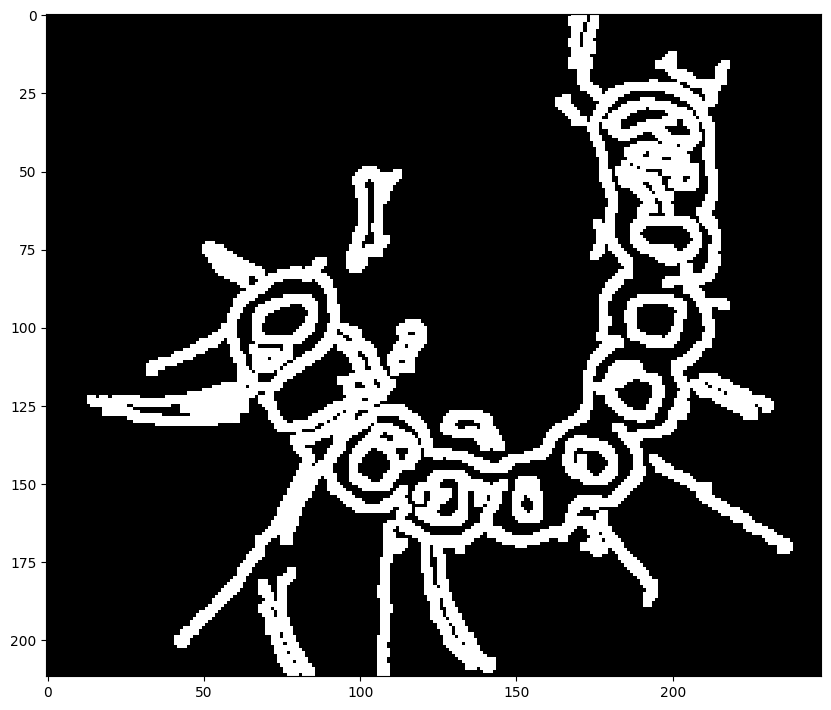

In [1]:
#3.1-PLOT THE IMAGE
import cv2
import matplotlib.pyplot as plt

# Configuration
image_path = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed\deneme_SA4point\SA1_flagged\SA1_low_score_processedimages\SA2_box_with_scores\SA2_flagged\low_score_processedimages\D20220514T091727_IFCB165.00129.png"

# Load the image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image with axis coordinates
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('on')
plt.show()


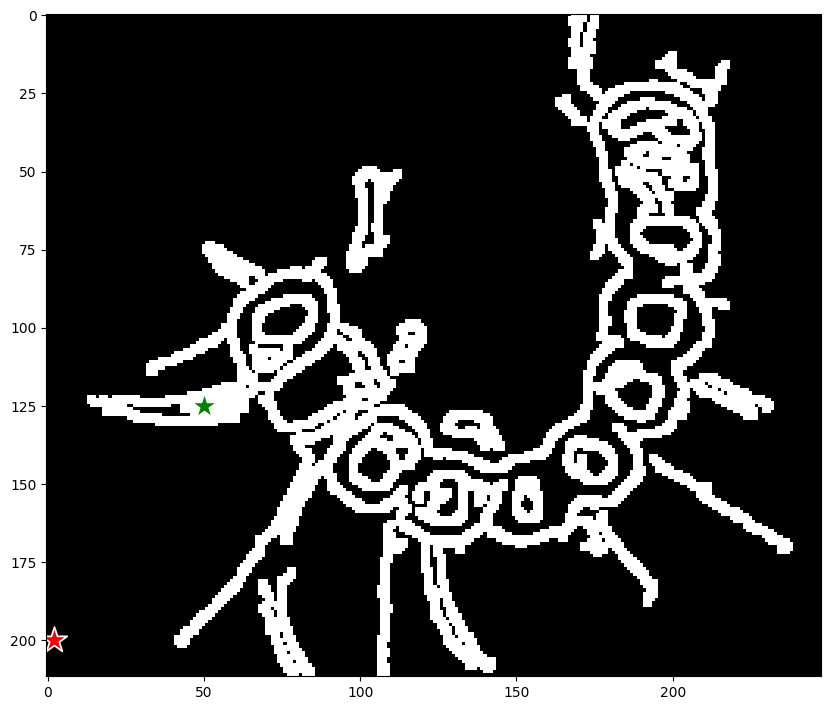

In [7]:
#3.2-PLOT THE INPUT TO VERIFY
#Green star foreground,red star background
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Define input points and labels
input_points = np.array([[50, 125], [2, 200]])
input_labels = np.array([1, 0])  # First point as foreground (green), second as background (red)

# Function to show points
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

# Plot the image with the input points
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
show_points(input_points, input_labels, plt.gca())
plt.axis('on')
plt.show()




In [8]:
predictor.set_image(image_rgb)#ran the model

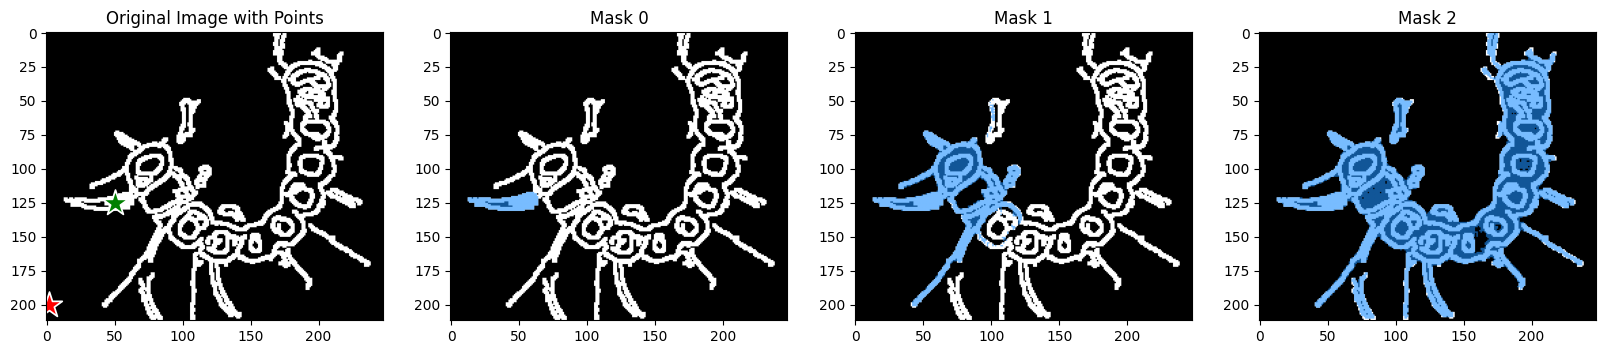

In [9]:
#3.3-GIVE MODEL PREDICTION INPUT AND PLOT THE MASKS for SELECTION
# Apply the predictor to get the masks
masks, _, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)

# Function to show mask
def show_mask(mask, ax, color=[30/255, 144/255, 255/255, 0.6]):  # Blue color by default
    h, w = mask.shape[-2:]
    mask_image = np.zeros((h, w, 4))
    mask_image[..., :3] = np.array(color[:3])
    mask_image[..., 3] = mask * color[3]
    ax.imshow(mask_image)

# Display the image with points and the resulting masks
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

# Original image with points
axs[0].imshow(image_rgb)
show_points(input_points, input_labels, axs[0])
axs[0].set_title("Original Image with Points")
axs[0].axis('on')

# Image with the generated masks
for i in range(3):
    axs[i + 1].imshow(image_rgb)
    show_mask(masks[i], axs[i + 1])
    axs[i + 1].set_title(f"Mask {i}")
    axs[i + 1].axis('on')

plt.show()

In [ ]:
#SAVES THE MASKS THE MANUALLY CHOSEN 
#Saves it as numpy, masked png, and blue-masked png
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Configuration
save_path = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed\deneme_SA4point\SA1_flagged\SA1_low_score_processedimages\SA2_box_with_scores\SA2_flagged"
os.makedirs(save_path, exist_ok=True)

# Select the mask with index 2
mask_index = 2
selected_mask = masks[mask_index]
selected_score = scores[mask_index]

# Ensure the directories exist
os.makedirs(save_path, exist_ok=True)

# Save the mask as a numpy array
base_filename = os.path.splitext(os.path.basename(image_path))[0]
npy_output_path = os.path.join(save_path, f"{base_filename}_mask2.npy")
np.save(npy_output_path, selected_mask)

# Save the mask as a binary image
binary_output_path = os.path.join(save_path, f"{base_filename}_mask2.png")
cv2.imwrite(binary_output_path, (selected_mask * 255).astype(np.uint8))

# Save the mask with a blue overlay and score
def save_mask_with_overlay(image, mask, score, output_path):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    h, w = mask.shape[-2:]
    mask_image = np.zeros((h, w, 4))
    mask_image[..., :3] = np.array([30/255, 144/255, 255/255])  # Blue color
    mask_image[..., 3] = mask * 0.6  # Alpha channel
    ax.imshow(mask_image)
    seg_score = segmentation_score(mask)
    ax.set_title(f"Mask 2 | Score: {score:.3f} | Seg. Score: {seg_score:.3f}")
    ax.axis('off')
    plt.savefig(output_path)
    plt.close()

plot_output_path = os.path.join(save_path, f"{base_filename}_mask2_with_score.png")
save_mask_with_overlay(image_rgb, selected_mask, selected_score, plot_output_path)

print(f"Saved mask 2 as .npy and .png with score to {save_path}")



Saved mask 2 as .npy and .png with score to D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202205\Processed_Folder\D20220514T091727_IFCB165_processed\deneme_SA4point\SA1_flagged\SA1_low_score_processedimages\SA2_box_with_scores\SA2_flagged
